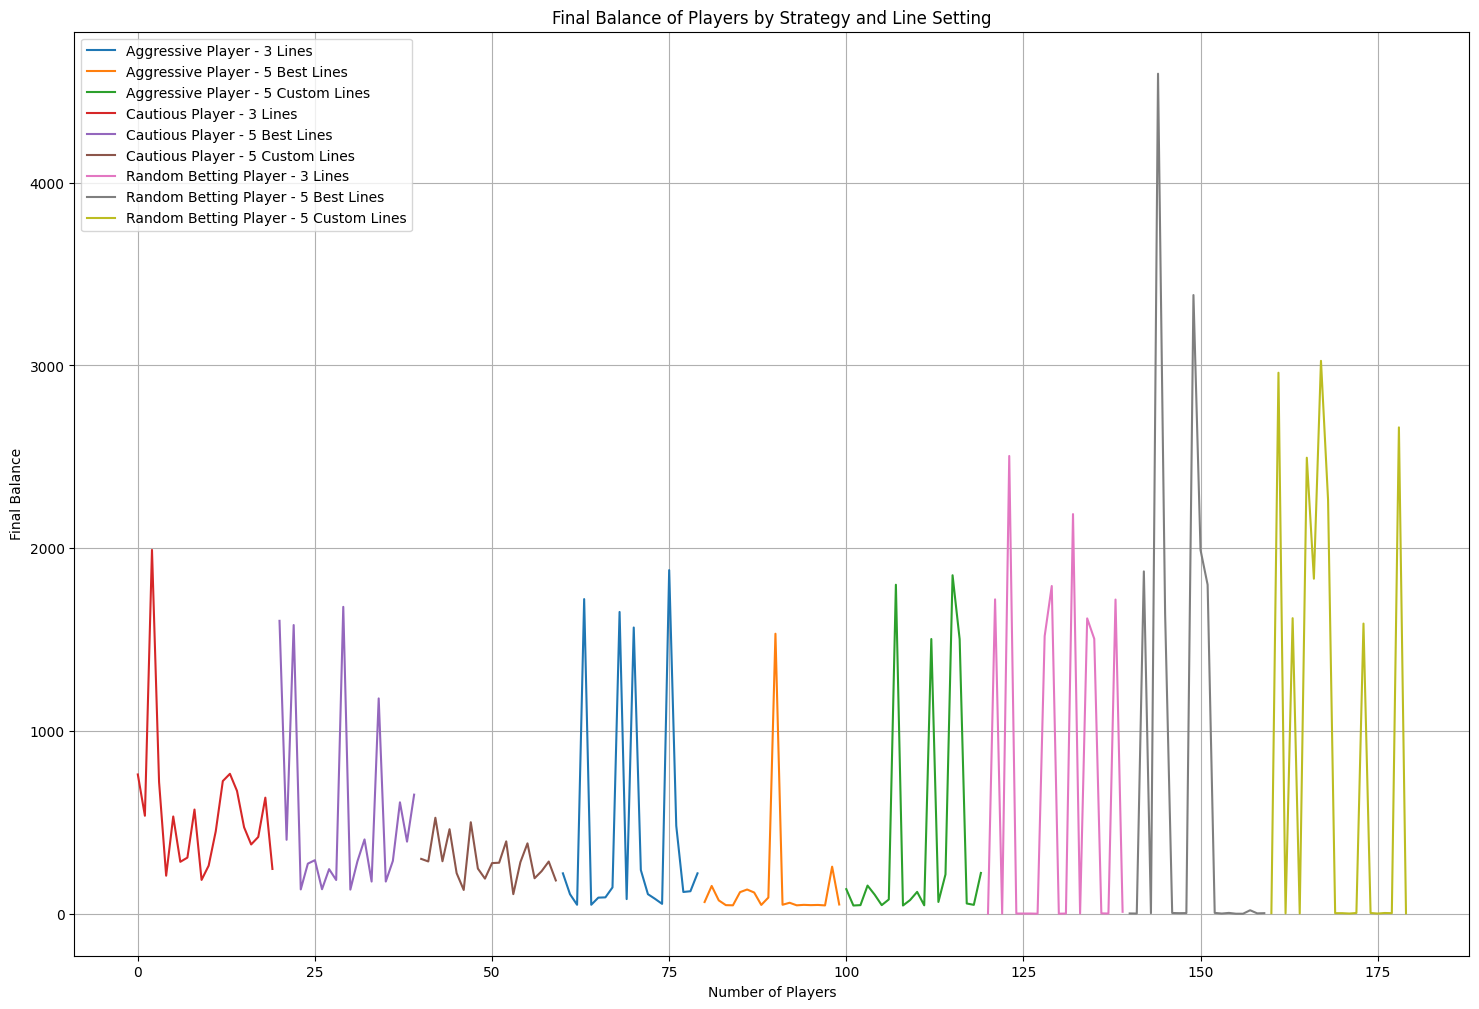

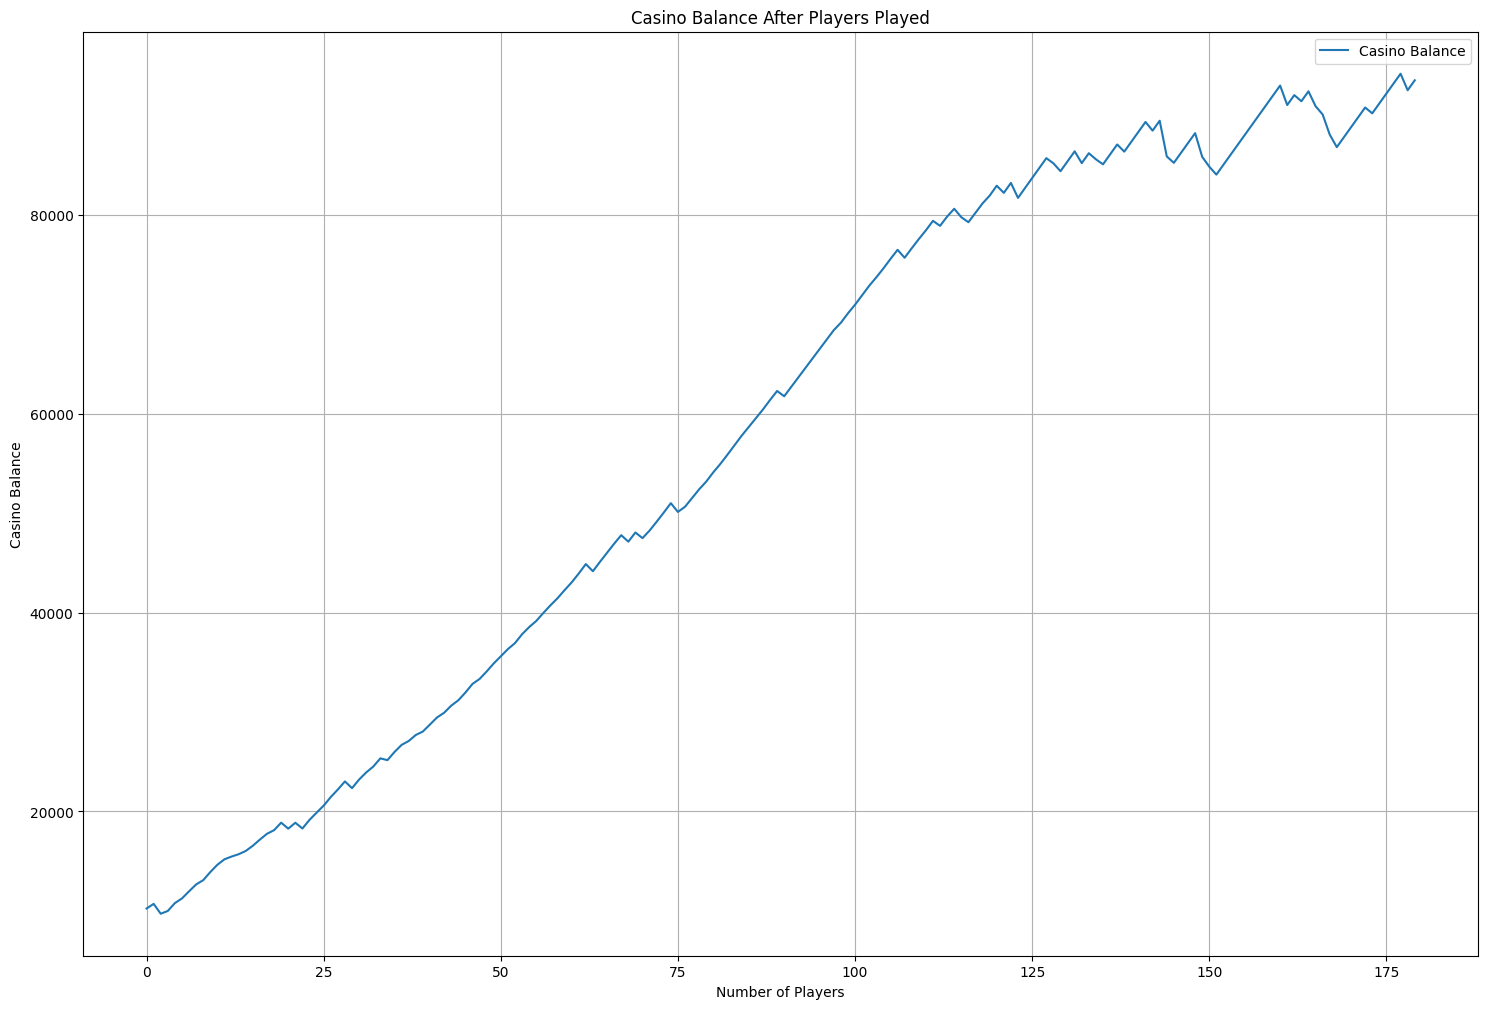

,strategy,lines,final_balance,casino_balance
0,Cautious Player,3 Lines,762.0,10238.0
1,Cautious Player,3 Lines,536.0,10702.0
2,Cautious Player,3 Lines,1990.5,9711.5
3,Cautious Player,3 Lines,720.5,9991.0
4,Cautious Player,3 Lines,208.0,10783.0
...,...,...,...,...
175,Random Betting Player,5 Custom Lines,1.0,92253.0
176,Random Betting Player,5 Custom Lines,4.0,93249.0
177,Random Betting Player,5 Custom Lines,3.0,94246.0
178,Random Betting Player,5 Custom Lines,2661.0,92585.0


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Constants
MAX_LINES = 5
MAX_BET = 100
MIN_BET = 1

ROWS = 3
COLS = 3

# Symbol definitions with probabilities and values
symbols = {
    "A": {"count": 1, "value": 20},
    "B": {"count": 3, "value": 15},
    "C": {"count": 5, "value": 10},
    "D": {"count": 7, "value": 8},
    "E": {"count": 9, "value": 5}
}

# Multiplier definitions
multipliers = {
    "A": 3,
    "B": 2.5,
    "C": 2,
    "D": 1.5,
    "E": 1.2
}

# Define custom lines
lines = [
    [(0, 0), (1, 0), (2, 0)],  # Top row
    [(0, 1), (1, 1), (2, 1)],  # Middle row
    [(0, 2), (1, 2), (2, 2)],  # Bottom row
    [(0, 0), (1, 1), (2, 2)],  # Top-left to bottom-right diagonal
    [(2, 0), (1, 1), (0, 2)]   # Bottom-left to top-right diagonal
]

def check_winnings_custom(columns, lines, bet, values, multipliers):
    winnings = 0
    for line in lines:
        symbol = columns[line[0][0]][line[0][1]]
        for position in line:
            if symbol != columns[position[0]][position[1]]:
                break
        else:
            winnings += values[symbol] * bet * multipliers[symbol]
    return winnings

def get_slot_machine_spin(rows, cols, symbols):
    all_symbols = []
    for symbol, symbol_info in symbols.items():
        for _ in range(symbol_info["count"]):
            all_symbols.append(symbol)

    columns = []
    for _ in range(cols):
        column = []
        current_symbols = all_symbols[:]
        for _ in range(rows):
            value = random.choice(current_symbols)
            current_symbols.remove(value)
            column.append(value)
        columns.append(column)

    return columns

def simulate_player_behavior(start_balance, num_spins, lines_to_bet, bet_strategy, win_increase=0.02, loss_decrease=0.02):
    balance = start_balance
    balances = []
    for i in range(num_spins):
        balances.append(balance)
        bet = bet_strategy(balance)
        total_bet = bet * len(lines_to_bet)
        if total_bet > balance:
            continue

        slots = get_slot_machine_spin(ROWS, COLS, symbols)
        winnings = check_winnings_custom(slots, lines_to_bet, bet, {k: v["value"] for k, v in symbols.items()}, multipliers)
        balance += winnings - total_bet

        if winnings > 0:
            bet = max(MIN_BET, min(int(bet * (1 + win_increase)), MAX_BET))
        else:
            bet = max(MIN_BET, int(bet * (1 - loss_decrease)))

        # Check if player leaves after winning 1.5 times their capital
        if balance >= start_balance * 1.5:
            break

    return balances, balance

def cautious_bet_strategy(balance):
    return max(MIN_BET, min(int(balance * 0.01), MAX_BET))

def aggressive_bet_strategy(balance):
    return min(int(balance * 0.02), MAX_BET)

def random_bet_strategy(balance):
    return max(MIN_BET, min(int(balance * random.uniform(0.01, 0.1)), MAX_BET))

# Simulation parameters
num_spins = 100
initial_balance = 1000
casino_initial_balance = 10000
num_players = 20

# Line settings
three_lines = lines[:3]
five_lines_best = lines
five_lines_custom = random.sample(lines, 3) + random.sample(lines, 2)

# Initialize casino balance
casino_balance = casino_initial_balance

# Simulate players
player_behaviors = [
    ("Cautious Player", cautious_bet_strategy),
    ("Aggressive Player", aggressive_bet_strategy),
    ("Random Betting Player", random_bet_strategy)
]

# Store results
results = {
    "strategy": [],
    "lines": [],
    "final_balance": [],
    "casino_balance": []
}

for player_type, bet_strategy in player_behaviors:
    for line_setting, line_desc in [(three_lines, "3 Lines"), (five_lines_best, "5 Best Lines"), (five_lines_custom, "5 Custom Lines")]:
        for _ in range(num_players):
            balances, final_balance = simulate_player_behavior(initial_balance, num_spins, line_setting, bet_strategy)
            casino_balance += (initial_balance - final_balance)
            results["strategy"].append(player_type)
            results["lines"].append(line_desc)
            results["final_balance"].append(final_balance)
            results["casino_balance"].append(casino_balance)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(18, 12))

# Plot player balances
for (player_type, line_desc), group in df_results.groupby(["strategy", "lines"]):
    plt.plot(group.index, group["final_balance"], label=f"{player_type} - {line_desc}")

plt.xlabel("Number of Players")
plt.ylabel("Final Balance")
plt.title("Final Balance of Players by Strategy and Line Setting")
plt.legend()
plt.grid(True)
plt.show()

# Plot casino balance
plt.figure(figsize=(18, 12))
plt.plot(df_results["casino_balance"], label="Casino Balance")
plt.xlabel("Number of Players")
plt.ylabel("Casino Balance")
plt.title("Casino Balance After Players Played")
plt.legend()
plt.grid(True)
plt.show()

df_results
